**Exercise lecture 2 (Mateus Dias Ribeiro)**

**ML for the solution of physics problems:**

Computational Fluid Dynamics (CFD) simulation by the numerical solution of the Navier-Stokes equations is an essential tool in a wide range of applications from engineering design to climate modeling. However, the computational cost and memory demand required by CFD codes may become very high for flows of practical interest, such as in aerodynamic shape optimization. This expense is associated with the complexity of the fluid flow governing equations, which include non-linear partial derivative terms that are of difficult solution, leading to long computational times and limiting the number of hypotheses that can be tested during the process of iterative design. Therefore, we propose DeepCFD: a convolutional neural network (CNN) based model that efficiently approximates solutions for the problem of non-uniform steady laminar flows. The proposed model is able to learn complete solutions of the Navier-Stokes equations, for both velocity and pressure fields, directly from ground-truth data generated using a state-of-the-art CFD code. Using DeepCFD, we found a speedup of up to 3 orders of magnitude compared to the standard CFD approach at a cost of low error rates.

**Dataset and code:**

A toy dataset and the code for this project can be downloaded using the following https://zenodo.org/record/3666056/files/DeepCFD.zip

The folder includes the files dataX and dataY, in which the first file provides the input information on the geometry of 981 channel flow samples, whereas the dataY file provides their ground-truth CFD solution for the velocity (Ux and Uy) and thepressure (p) fields using the simpleFOAM solver. Figure 1 describes the structure of each of these files in detail:

![CFDAI](https://raw.githubusercontent.com/mdribeiro/DeepCFD/master/ReadmeFiles/DataStruct.png)
> Figure 1. DeepCFD toy dataset structure.

Both dataX and dataY have the same number of dimensions (Ns, Nc, Nx, Ny), in which the first axis is the number of samples (Ns), the second axis is the number of channels (Nc), and third and fourth axes are the number of elements in x and y (Nx and Ny). Regarding the input dataX, the first channel is the SDF calculated from the obstacle's surface, the second channel is the multi-label flow region channel, and the third channel is the SDF from the top/bottom surfaces. For the output dataY file, the first channel is the Ux horizontal velocity component, the second channel is the Uy vertical velocity component, and the third channel is the pressure field.

First, let's load some necessary dependencies:

In [2]:
!git clone https://git.opendfki.de/mateus.dias_ribeiro/supplementaryphysics.git
!mv supplementaryphysics/*  .
!rm -r supplementaryphysics
!pip install scikit-fmm==0.0.7

Cloning into 'supplementaryphysics'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 33 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (33/33), done.
     |████████████████████████████████| 235kB 14.1MB/s 
  Created wheel for scikit-fmm: filename=scikit_fmm-0.0.7-cp36-cp36m-linux_x86_64.whl size=155181 sha256=2db3d890214f63d9f8623e2196a399e50fb8363954561a1e08d86caff461a7f8
  Stored in directory: /root/.cache/pip/wheels/15/b6/5b/131eca30948459595b3a336a3425d3f824a8b22f23bb979d47
Successfully built scikit-fmm


**Exercise 1:**

In the next code snippet, you will learn the first step of our CNN for fluids application, which involves converting the data obtained by the solution of the Navier-Stokes equations from a tabular format (as produced by the CFD code) into a tensor format, which can be later read by our CNN network. As discussed in the class, in order to give the CNN network the understanding about the geometry of the domain to be able to find a mapping between the geometry information (X) and the desired outputs (velocity fields ux, uy, and pressure field, Y), we need to calculate the SDF (signed distance function) field around the obstacle for each training sample. The script below shows us how to do this for 10 training samples. First, we create a tensor/numpy array to store the information about the calculated velocity and pressure at each grid location. It is important to notice that at this point we do a down sampling step, meaning that the number of data points to be used for training of the CNN is smaller than the number of points calculated in the simulation (this will make things faster to train). The tensor will have dimensions (Ns, Nx, Ny, Nc), in which Ns represents the number of samples, Nx/Ny the number of points in x and y, and Nc the number of variables we are saving (x, y information, velocity field, pressure field, etc. 

For this exercise, use the skfmm package, which is an implementation of the fast marching method, to calculate the desired SDF fields from the tensor named grid. After that, create a plot function to plot both input and output tensors that we need to train our CNN model. Plot both X (SFD, binary mask) and Y (velocity, pressure) channels as shown in the Figure 1, i.e. use the first column for the 3 channels in X and the second column for the 3 channels in Y.

Data 0 loaded!
Data 1 loaded!
Data 2 loaded!
Data 3 loaded!
Data 4 loaded!
Data 5 loaded!
Data 6 loaded!
Data 7 loaded!
Data 8 loaded!
Data 9 loaded!
All data loaded!
Mesh: 0
Grid dimensions: (172, 79, 1)


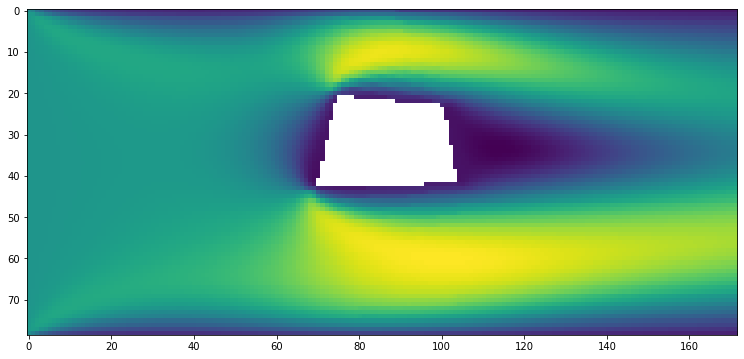

Mesh: 1
Grid dimensions: (172, 79, 1)


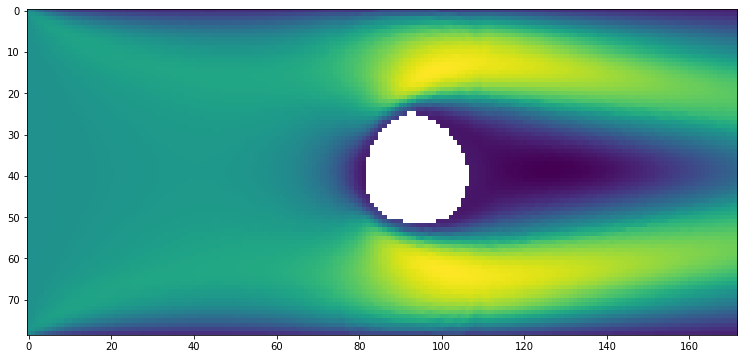

Mesh: 2
Grid dimensions: (172, 79, 1)


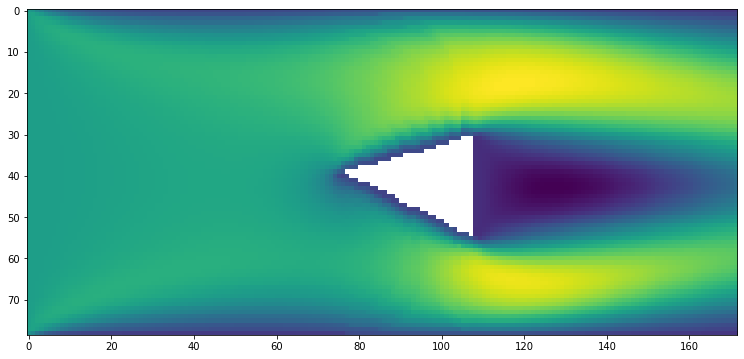

Mesh: 3
Grid dimensions: (172, 79, 1)


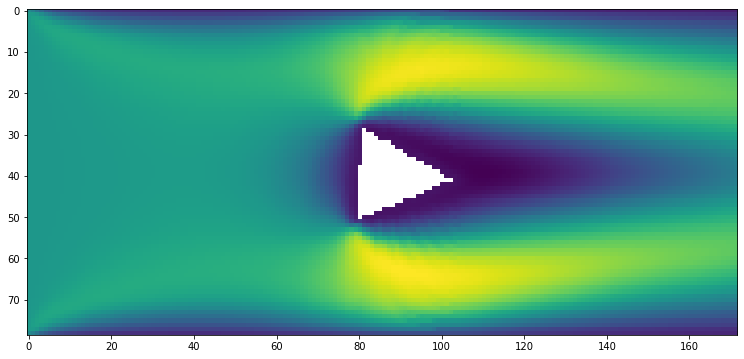

Mesh: 4
Grid dimensions: (172, 79, 1)


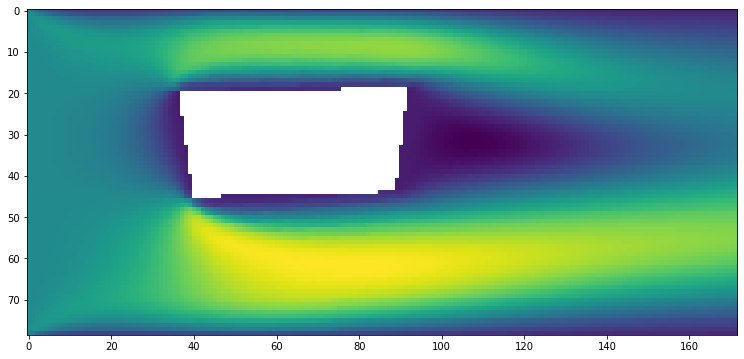

Mesh: 5
Grid dimensions: (172, 79, 1)


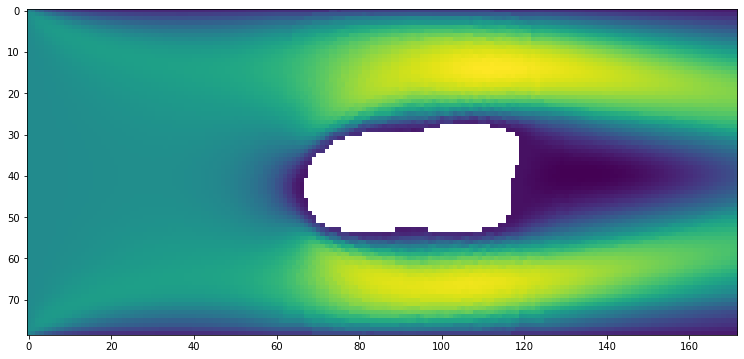

Mesh: 6
Grid dimensions: (172, 79, 1)


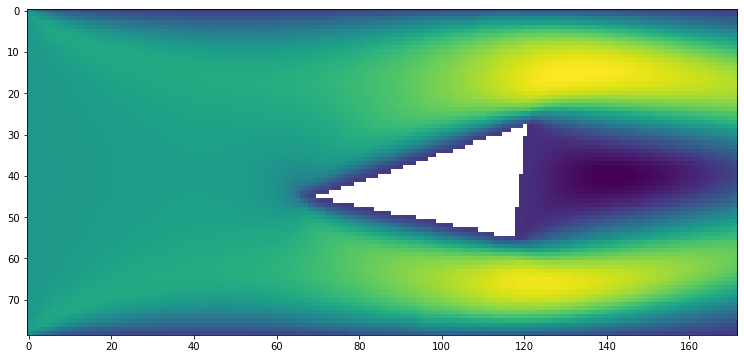

Mesh: 7
Grid dimensions: (172, 79, 1)


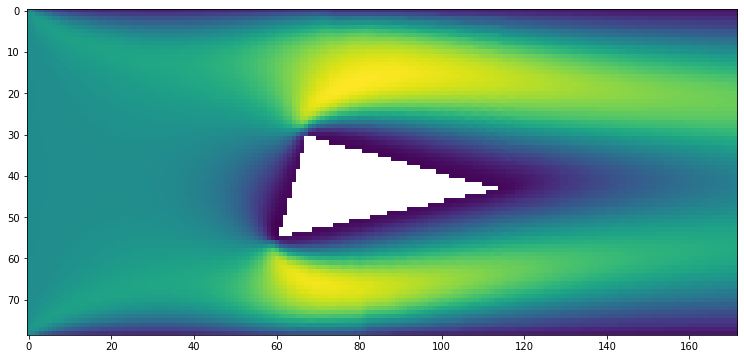

Mesh: 8
Grid dimensions: (172, 79, 1)


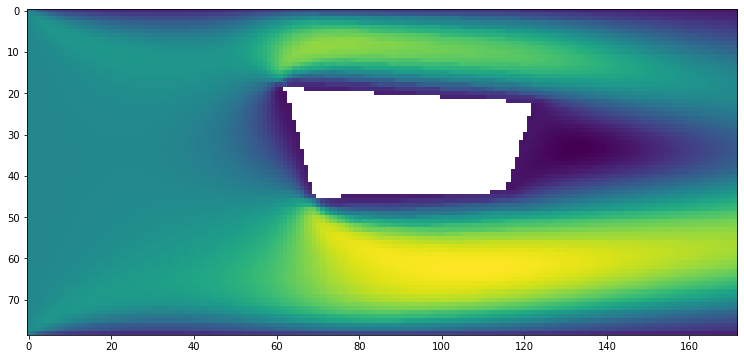

Mesh: 9
Grid dimensions: (172, 79, 1)


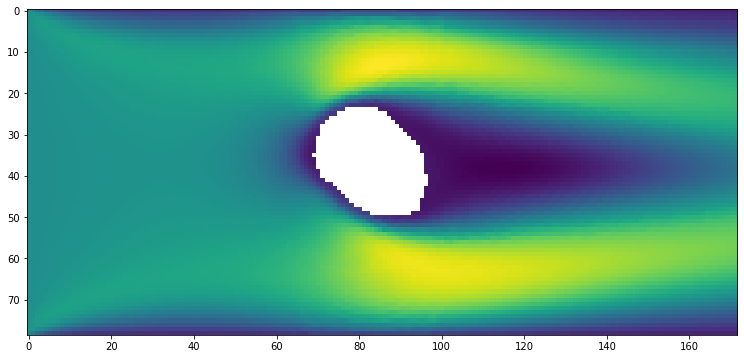

In [3]:
import torch
import pandas as pd
import numpy as np

import skfmm
import pickle

import matplotlib.pyplot as plt

def load_data(file, max_rows=1024 * 1024 * 2):
    return pd.read_csv(file, nrows=max_rows)

n_samples = 10
   
Xs = []    
Ys = []

dataAll = []
for i in range(n_samples):

    device = "cpu"
    x_col = "x"
    y_col = "y"
    z_col = "z"
    target_col = "U:0"
      
    data_i = load_data("./Data/cfdSample_" + str(i) + ".csv", max_rows=100000000000)
    dataAll.append(data_i)
    print("Data " + str(i) +  " loaded!")
    
print("All data loaded!")
for i in range(n_samples):

    data = dataAll[i]
    
    x, y, z, target = data[x_col].values, data[y_col].values, data[z_col].values, data[target_col].values
    x, y, z, target = torch.FloatTensor(x).to(device), torch.FloatTensor(y).to(device), torch.FloatTensor(z).to(device), torch.FloatTensor(target)
    features = [torch.FloatTensor(data[p]).to(device) for p in data.keys()]

    print("Mesh: " + str(i))

    x_sorted, x_index = torch.sort(x)
    y_sorted, y_index = torch.sort(y)
    z_sorted, z_index = torch.sort(z)

    min_x, max_x = float(x_sorted[0]), float(x_sorted[-1])
    min_y, max_y = float(y_sorted[0]), float(y_sorted[-1])
    min_z, max_z = float(z_sorted[0]), float(z_sorted[-1])
    
    cell_x, cell_y, cell_z = 0.0015,0.0015,0.0015
    x_diff, y_diff, z_diff = x_sorted[1:] - x_sorted[:-1], y_sorted[1:] - y_sorted[:-1],  torch.FloatTensor(np.array( [0, cell_z])).to(device) 


    len_x, len_y, len_z = (max_x - min_x) / cell_x, (max_y - min_y) / cell_y, (max_z - min_z) / cell_z
    len_x, len_y, len_z = int(len_x), int(len_y), 1

    print("Grid dimensions: " + str((len_x, len_y, len_z)))     
    
    const = 0.01
    lpos = 1.0 + const
    lneg = 1.0 - const
    
    grid = torch.zeros(len_x, len_y, len_z, len(features)).to(device)
    
    for _x in range(len_x):
        for _y in range(len_y):
            for _z in range(len_z):
                
                cell_space = ( x >= 10000000000000000) # Just create a vector with Falses
                
                const = cell_x/2
                for i in range(1):
                    const = const + const*i
                    cell_min_x, cell_max_x = -const + min_x + cell_x * _x, const + min_x + cell_x * (_x + 1)
                    cell_min_y, cell_max_y = -const + min_y + cell_y * _y, const + min_y + cell_y * (_y + 1)
                    cell_min_z, cell_max_z = -const + min_z + cell_z * _z, const + min_z + cell_z * (_z + 1)
                    cell_space_i = (x >= cell_min_x) & (x < cell_max_x) & (y >= cell_min_y) & (y < cell_max_y)
                    cell_space = cell_space + cell_space_i                  

                pcell = int(torch.sum(cell_space.type(torch.int)))
                cell_features = torch.stack([torch.mean(feature[cell_space]) for feature in features])                       
                grid[_x, _y, _z, :] = cell_features
                
    grid = grid.cpu().detach().numpy()

    ###############################################################
    ##### Your code to calculate SDF using skfmm package here #####
    ###############################################################
    
    index = np.argwhere(np.isnan(grid[:,:,0,7]))
    phi = 1*np.ones(grid[:,:,0,0].shape)
    sdf = np.array(phi, copy=True)
    sdf[index[:,0],index[:,1]] = -1
    
    sdf2 = np.array(phi, copy=True)
    sdf2[:,0] = -1
    sdf2[:,sdf2.shape[1]-1] = -1
    
    d = skfmm.distance(sdf, dx = 1e-2)
    d[index[:,0],index[:,1]] = -50
    
    d2 = skfmm.distance(sdf2, dx = 1e-2)
    d2[index[:,0],index[:,1]] = -50    # Maybe include this to assign zero to obstacle!

    X = np.zeros((grid.shape[0],grid.shape[1],3))
    X[:,:,0] = d[:,:]
    X[:,:,1] = grid[:,:,0,4].reshape((grid.shape[0],grid.shape[1]))
    X[:,:,2] = d2[:,:]

    mask = (1 - np.isnan(X[:,:,1:2]))   #.type(torch.float))
    mask[0,:,:] = 3
    mask[171,:,:] = 4
    mask[:,0,:] = 2
    mask[:,78,:] = 2

    X[:,:,1:2] = mask[:,:,0:1]
    
    Xs.append(X)
    
    Y = np.zeros((grid.shape[0],grid.shape[1],3))
    Y[:,:,0] = grid[:,:,0,0].reshape((grid.shape[0],grid.shape[1]))
    Y[:,:,1] = grid[:,:,0,1].reshape((grid.shape[0],grid.shape[1]))
    Y[:,:,2] = grid[:,:,0,3].reshape((grid.shape[0],grid.shape[1]))
    
    Ys.append(Y)
    
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(15, 6)
    plt.imshow(np.transpose(grid[:,:,0,0]))
    plt.show()

Xsn = np.asarray(Xs)
Ysn = np.asarray(Ys)

pickle.dump( Xsn, open( "xCylinder.pkl", "wb" ) )
pickle.dump( Ysn, open( "yCylinder.pkl", "wb" ) )

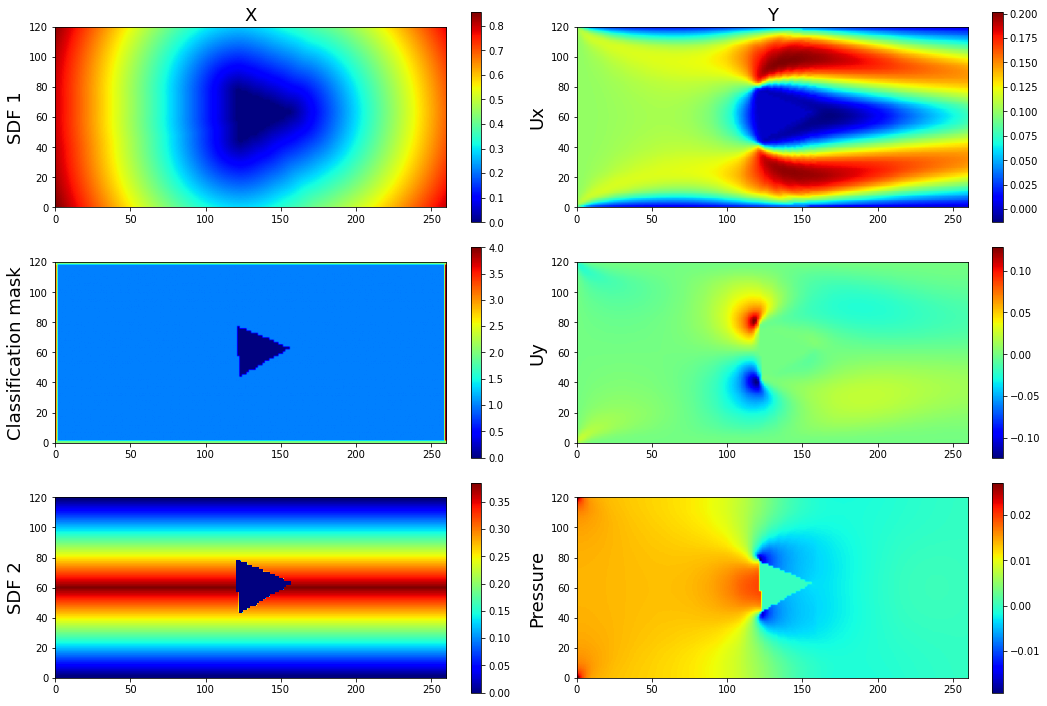

In [4]:
##########################################
##### Your code to plot X and Y here #####
##########################################

def plotData(X, Y, s):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
    plt.subplot(3, 2, 1)
    plt.title('X', fontsize=18)
    plt.imshow(np.transpose(X[s, :, :, 0]), cmap='jet', vmin = 0, vmax = np.max(X[s, :, :, 0]), origin='lower', extent=[0,260,0,120])
    plt.colorbar(orientation='vertical')
    plt.ylabel('SDF 1', fontsize=18)
    plt.subplot(3, 2, 2)
    plt.title('Y', fontsize=18)
    plt.imshow(np.transpose(Y[s, :, :, 0]), cmap='jet', vmin = np.min(Y[s, :, :, 0]), vmax = np.max(Y[s, :, :, 0]), origin='lower', extent=[0,260,0,120])
    plt.colorbar(orientation='vertical')
    plt.ylabel('Ux', fontsize=18)

    plt.subplot(3, 2, 3)
    plt.imshow(np.transpose(X[s, :, :, 1]), cmap='jet', vmin = np.min(X[s, :, :, 1]), vmax = np.max(X[s, :, :, 1]), origin='lower', extent=[0,260,0,120])
    plt.colorbar(orientation='vertical')
    plt.ylabel('Classification mask', fontsize=18)
    plt.subplot(3, 2, 4)
    plt.imshow(np.transpose(Y[s, :, :, 1]), cmap='jet', vmin = np.min(Y[s, :, :, 1]), vmax = np.max(Y[s, :, :, 1]), origin='lower', extent=[0,260,0,120])
    plt.colorbar(orientation='vertical')
    plt.ylabel('Uy', fontsize=18)

    plt.subplot(3, 2, 5)
    plt.imshow(np.transpose(X[s, :, :, 2]), cmap='jet', vmin = 0, vmax = np.max(X[s, :, :, 2]), origin='lower', extent=[0,260,0,120])
    plt.colorbar(orientation='vertical')
    plt.ylabel('SDF 2', fontsize=18)
    plt.subplot(3, 2, 6)
    plt.imshow(np.transpose(Y[s, :, :, 2]), cmap='jet', vmin = np.min(Y[s, :, :, 2]), vmax = np.max(Y[s, :, :, 2]), origin='lower', extent=[0,260,0,120])
    plt.colorbar(orientation='vertical')
    plt.ylabel('Pressure', fontsize=18)

    plt.tight_layout()
    plt.show()

x = np.nan_to_num(Xsn)
y = np.nan_to_num(Ysn)
plotData(x, y, np.random.randint(x.shape[0]))

Load some other packages we are going to need to train our model:

In [5]:
import os
import json
import torch
import pickle
from train_functions import *
from functions import *
import torch.optim as optim
from torch.utils.data import TensorDataset
from Models.UNetEx import UNetEx

Now let's download the entired dataset (already post-processed with 981 samples for X and Y) and load it to our colab environment:

In [6]:
!wget https://zenodo.org/record/3665511/files/dataX.pkl
!wget https://zenodo.org/record/3665511/files/dataY.pkl

--2020-11-17 14:10:10--  https://zenodo.org/record/3665511/files/dataX.pkl
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159958102 (153M) [application/octet-stream]
Saving to: ‘dataX.pkl’

dataX.pkl           100%[===================>] 152.55M  10.7MB/s    in 14s     

2020-11-17 14:10:25 (10.9 MB/s) - ‘dataX.pkl’ saved [159958102/159958102]

--2020-11-17 14:10:26--  https://zenodo.org/record/3665511/files/dataY.pkl
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159958102 (153M) [application/octet-stream]
Saving to: ‘dataY.pkl’

dataY.pkl           100%[===================>] 152.55M  6.62MB/s    in 17s     

2020-11-17 14:10:44 (8.92 MB/s) - ‘dataY.pkl’ saved [159958102/159958102]



In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = pickle.load(open("./dataX.pkl", "rb"))
y = pickle.load(open("./dataY.pkl", "rb"))

**Exercise 2:**

In this exercise we would like you to setup the problem. Modify the code snippet below to call the UNetEx architecture we discussed in the class with the following hyperparmeters:

lr = 0.001

CNN filtre size = 5

Number of CNN layers in each encoding/decoding part = 4

Number of filters in each layer at Encoder = 8 in 1st layer, 16 in 2nd layer, 32 in 3rd layer and 32 in 4th layer

Number of filters in each layer at Decoder = 32 in 1st layer, 32 in 2nd layer, 16 in 3rd layer and 8 in 4th layer

Weight decay = 0.005

Batch norm = False

Weight norm = False

Optimizer = AdamW

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)    
channels_weights = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1).reshape((981*172*79,3)) ** 2, dim=0)).view(1, -1, 1, 1).to(device)
print(channels_weights)

simulation_directory = "./Run/"
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)

train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)        
test_x, test_y = test_dataset[:]

##########################
##### Your code here #####
##########################

torch.manual_seed(0)
lr = 0.001
kernel_size = 5
filters = [8, 16, 32, 32]
bn = False
wn = False
wd = 0.005
model = UNetEx(3, 3, filters=filters, kernel_size=kernel_size, batch_norm=bn, weight_norm=wn)
# Define opotimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd) 

tensor([[[[0.1153]],

         [[0.0175]],

         [[0.0135]]]], device='cuda:0')


**Exercise 3:**

In this exercise, define the loss function for each of the outputs (ux, uy, p). For ux and uy, use the L2-norm. For the pressure p, use the L1-norm. Sum all three error values to one single "loss" variable. Normalize the loss by dividing it by the channel weights calculated in previous cell.

In [9]:
def loss_func(model, batch):
    x, y = batch
    output = model(x)
    lossu = ((output[:,0,:,:] - y[:,0,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    lossv = ((output[:,1,:,:] - y[:,1,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    lossp = torch.abs((output[:,2,:,:] - y[:,2,:,:])).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    loss = (lossu + lossv + lossp)/channels_weights
    return torch.sum(loss), output

In the next cell we train the model for 300 epochs:

In [10]:
config = {}        
train_loss_curve = []
test_loss_curve = []
train_mse_curve = []
test_mse_curve = []
train_ux_curve = []
test_ux_curve = []
train_uy_curve = []
test_uy_curve = []
train_p_curve = []
test_p_curve = []

def after_epoch(scope):
    train_loss_curve.append(scope["train_loss"])
    test_loss_curve.append(scope["val_loss"])
    train_mse_curve.append(scope["train_metrics"]["mse"])
    test_mse_curve.append(scope["val_metrics"]["mse"])
    train_ux_curve.append(scope["train_metrics"]["ux"])
    test_ux_curve.append(scope["val_metrics"]["ux"])
    train_uy_curve.append(scope["train_metrics"]["uy"])
    test_uy_curve.append(scope["val_metrics"]["uy"])
    train_p_curve.append(scope["train_metrics"]["p"])
    test_p_curve.append(scope["val_metrics"]["p"])

# Training model
DeepCFD, train_metrics, train_loss, test_metrics, test_loss = train_model(model, loss_func, train_dataset, test_dataset, optimizer,
    epochs=300, batch_size=64, device=device,    #epochs=1000, batch_size=64, device=device,
    m_mse_name="Total MSE",
    m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
    m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
    m_ux_name="Ux MSE",
    m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
    m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
    m_uy_name="Uy MSE",
    m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
    m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
    m_p_name="p MSE",
    m_p_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
    m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]), patience=25, after_epoch=after_epoch
    )
    
metrics = {}
metrics["train_metrics"] = train_metrics
metrics["train_loss"] = train_loss
metrics["test_metrics"] = test_metrics
metrics["test_loss"] = test_loss
curves = {}
curves["train_loss_curve"] = train_loss_curve
curves["test_loss_curve"] = test_loss_curve
curves["train_mse_curve"] = train_mse_curve
curves["test_mse_curve"] = test_mse_curve
curves["train_ux_curve"] = train_ux_curve
curves["test_ux_curve"] = test_ux_curve
curves["train_uy_curve"] = train_uy_curve
curves["test_uy_curve"] = test_uy_curve
curves["train_p_curve"] = train_p_curve
curves["test_p_curve"] = test_p_curve
config["metrics"] = metrics
config["curves"] = curves
with open(simulation_directory + "results.json", "w") as file:
    json.dump(config, file)

Epoch #1
	Train Loss = 210479491.0
	Train Total MSE = 1934.4248417000729
	Train Ux MSE = 1807.009409734876
	Train Uy MSE = 113.34839765810062
	Train p MSE = 14.067044138560837
	Validation Loss = 49672099.0
	Validation Total MSE = 1052.227409957627
	Validation Ux MSE = 1029.1906647245762
	Validation Uy MSE = 19.494846977621823
	Validation p MSE = 3.5419187384136652
Model saved!
Epoch #2
	Train Loss = 107280538.0
	Train Total MSE = 984.5567260386298
	Train Ux MSE = 964.7292103225219
	Train Uy MSE = 16.87744763432717
	Train p MSE = 2.9500341276385695
	Validation Loss = 41784439.0
	Validation Total MSE = 890.7999470338983
	Validation Ux MSE = 872.3851430084745
	Validation Uy MSE = 15.700439246226166
	Validation p MSE = 2.7143518738827463
Model saved!
Epoch #3
	Train Loss = 88103611.0
	Train Total MSE = 807.5612985149417
	Train Ux MSE = 790.830391308309
	Train Uy MSE = 14.3745582513837
	Train p MSE = 2.356352147138501
	Validation Loss = 32249648.0
	Validation Total MSE = 694.158845338983
	V

**Exercise 4:**

In this exercise, create another plot function to plot the results of our training and compare it to the ground-truth. For that, build a 3 x 3 plot matrix, in which the first column presents the results of the ground-truth CFD, the second column shows the results by the CNN model, and the third column shows the absolute error between the first and second columns (i.e. between ground-truth and CNN output).

In [11]:
##########################
##### Your code here #####
##########################

def visualize(sample_y, out_y, error, s):
           
    minu = np.min(sample_y[s, 0, :, :])
    maxu = np.max(sample_y[s, 0, :, :])
    
    minv = np.min(sample_y[s, 1, :, :])
    maxv = np.max(sample_y[s, 1, :, :])
    
    minp = np.min(sample_y[s, 2, :, :])
    maxp = np.max(sample_y[s, 2, :, :])
    
    mineu = np.min(error[s, 0, :, :])
    maxeu = np.max(error[s, 0, :, :])
    
    minev = np.min(error[s, 1, :, :])
    maxev = np.max(error[s, 1, :, :])
    
    minep = np.min(error[s, 2, :, :])
    maxep = np.max(error[s, 2, :, :])
           
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
    plt.subplot(3, 3, 1)
    plt.title('CFD', fontsize=18)
    plt.imshow(np.transpose(sample_y[s, 0, :, :]), cmap='jet', vmin = minu, vmax = maxu, origin='lower', extent=[0,260,0,120])
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Ux', fontsize=18)
    plt.subplot(3, 3, 2)
    plt.title('CNN', fontsize=18)
    plt.imshow(np.transpose(out_y[s, 0, :, :]), cmap='jet', vmin = minu, vmax = maxu, origin='lower', extent=[0,260,0,120])
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 3)
    plt.title('Error', fontsize=18)
    plt.imshow(np.transpose(error[s, 0, :, :]), cmap='jet', vmin = mineu, vmax = maxeu, origin='lower', extent=[0,260,0,120])
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 4)
    plt.imshow(np.transpose(sample_y[s, 1, :, :]), cmap='jet', vmin = minv, vmax = maxv, origin='lower', extent=[0,260,0,120])
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Uy', fontsize=18)
    plt.subplot(3, 3, 5)
    plt.imshow(np.transpose(out_y[s, 1, :, :]), cmap='jet', vmin = minv, vmax = maxv, origin='lower', extent=[0,260,0,120])
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 6)
    plt.imshow(np.transpose(error[s, 1, :, :]), cmap='jet', vmin = minev, vmax = maxev, origin='lower', extent=[0,260,0,120])
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 7)
    plt.imshow(np.transpose(sample_y[s, 2, :, :]), cmap='jet', vmin = minp, vmax = maxp, origin='lower', extent=[0,260,0,120])
    plt.colorbar(orientation='horizontal')
    plt.ylabel('p', fontsize=18)
    plt.subplot(3, 3, 8)
    plt.imshow(np.transpose(out_y[s, 2, :, :]), cmap='jet', vmin = minp, vmax = maxp, origin='lower', extent=[0,260,0,120])
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 9)
    plt.imshow(np.transpose(error[s, 2, :, :]), cmap='jet', vmin = minep, vmax = maxep, origin='lower', extent=[0,260,0,120])
    plt.colorbar(orientation='horizontal')
    plt.tight_layout()
    plt.show()

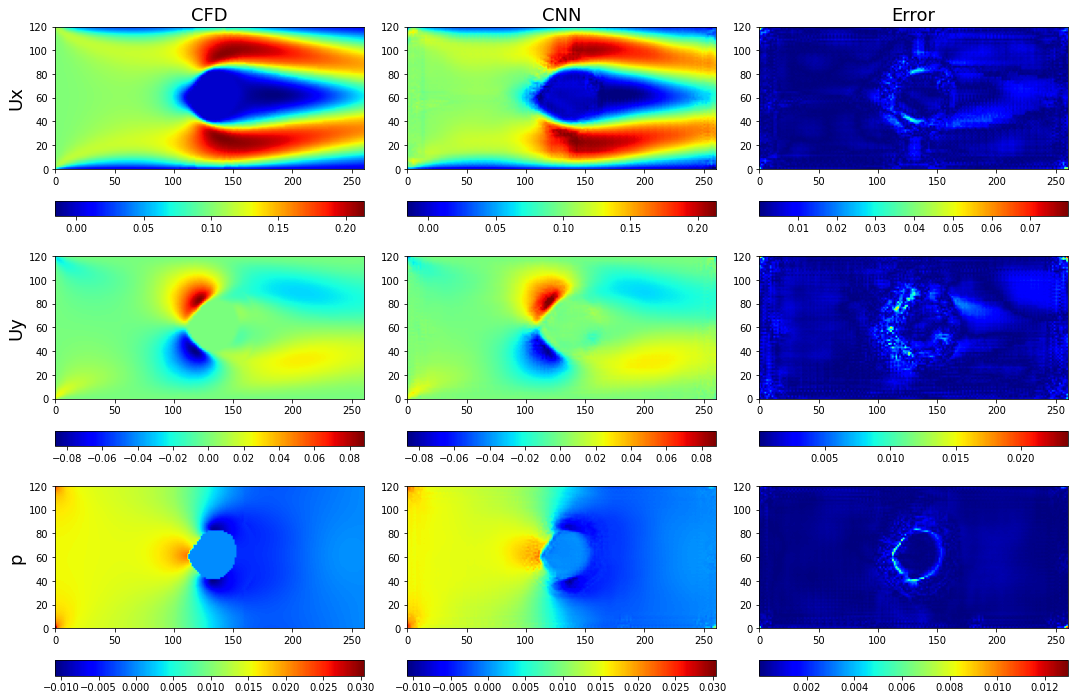

In [12]:
out = DeepCFD(test_x.to(device))
error = torch.abs(out.cpu() - test_y.cpu())
s =np.random.randint(test_x.shape[0])
visualize(test_y.cpu().detach().numpy(), out.cpu().detach().numpy(), error.cpu().detach().numpy(), s)

**Exercise 5:**

Go back to exercise 2 and try different model configurations, such as:

Different architectures (UNet, AutoEncoder...)
Different hyperparameters (filter size, number of filters, learning rate...)

Train the model and plot the results again. How did the above alterations alter the results?